<a href="https://colab.research.google.com/github/ggsmith842/pytorch-tutorials/blob/main/Mistral_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install mistralai datasets ipywidgets -Uq

In [3]:
import os
import time
import nltk
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from time import sleep
from mistralai import Mistral
from google.colab import userdata
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset

In [28]:
from sklearn.decomposition import PCA
import altair as alt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# load imdb dataset from huggingface
ds = load_dataset("stanfordnlp/imdb")

In [9]:
merged_dataset = concatenate_datasets([ds['train'], ds['test']])
split_dataset = merged_dataset.train_test_split(test_size=0.25, shuffle=True, seed=42)

train = split_dataset['train']
test = split_dataset['test']

In [12]:
def get_embeddings_by_chunk(data, chunk_size):
  client = Mistral(userdata.get('MISTRAL_API_KEY'))
  chunks = [data[x: x + chunk_size] for x in range(0, len(data), chunk_size)]
  embeddings_resp = []
  for c in tqdm(chunks):
    embeddings_resp.append(client.embeddings.create(model='mistral-embed', inputs = c))
    sleep(2)
  return [d.embedding for e in embeddings_resp for d in e.data]

In [14]:
train_embeddings = get_embeddings_by_chunk(train['text'][:3000], 150)
test_embeddings = get_embeddings_by_chunk(test['text'][:300], 150)

In [50]:
train_dataset = TensorDataset(
    torch.from_numpy(np.array(train_embeddings)).float().to(device),
    torch.from_numpy(np.array(train['label'][:3000])).float().to(device)
)

test_dataset = TensorDataset(
    torch.from_numpy(np.array(test_embeddings)).float().to(device),
    torch.from_numpy(np.array(test['label'][:300])).float().to(device)
)

In [51]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [52]:
train_data_features, train_labels = next(iter(train_dataloader))
print(f'Example Input Size: {train_data_features.size()}')
print(f'Example Input:\n {train_data_features}\n')

print(f'Example Output Size: {train_labels.size()}')
print(f'Example Output:\n {train_labels}')

Example Input Size: torch.Size([32, 1024])
Example Input:
 tensor([[-0.0516,  0.0179,  0.0342,  ..., -0.0093,  0.0040, -0.0022],
        [-0.0499,  0.0158,  0.0440,  ...,  0.0110, -0.0060, -0.0232],
        [-0.0050,  0.0148,  0.0416,  ..., -0.0082, -0.0077, -0.0276],
        ...,
        [-0.0256,  0.0092,  0.0081,  ..., -0.0243,  0.0072,  0.0152],
        [-0.0211,  0.0359,  0.0274,  ..., -0.0246,  0.0153, -0.0188],
        [-0.0382,  0.0211,  0.0370,  ...,  0.0066, -0.0110, -0.0024]])

Example Output Size: torch.Size([32])
Example Output:
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.])


In [29]:
pca = PCA(n_components=10)
pc_embeds = pca.fit_transform(train_embeddings)

In [42]:
import seaborn as sns
import pandas as pd

<Axes: >

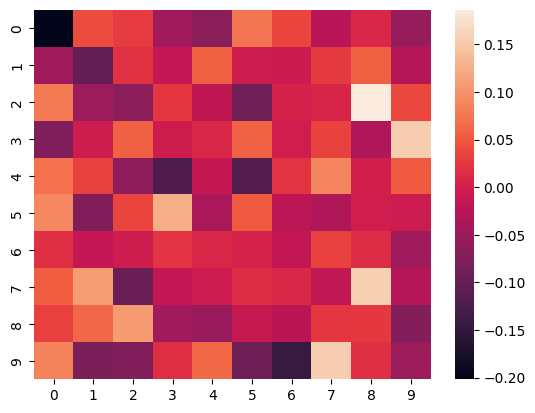

In [41]:
sns.heatmap(pd.DataFrame(pc_embeds).head(10))

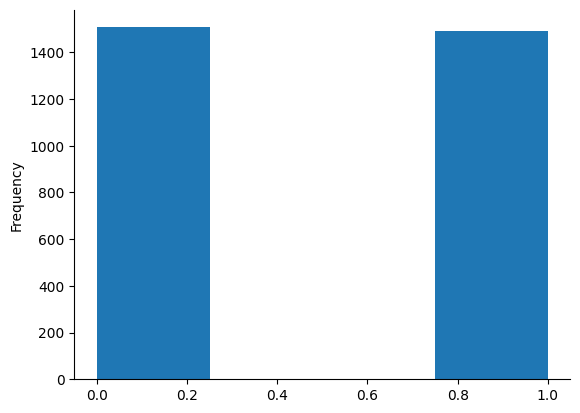

In [64]:
from matplotlib import pyplot as plt
pd.DataFrame(train['label'][:3000])[0].plot(kind='hist', bins=4, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [43]:
# create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [44]:
def accuracy_metric(predictions, labels):
  """Returns 0-1 accuracy for the given set of predictions and labels"""
  rounded_predictions = torch.round(torch.sigmoid(predictions))
  success = (rounded_predictions == labels).float()
  return success.sum() / len(success)

In [45]:
def training_loop(model, dataloader, optim, loss_func):
  loss = 0
  accuracy = 0
  model.train()

  for seq, sentiment in dataloader:
    optim.zero_grad()
    predictions = model(seq).squeeze()
    loss_curr = loss_func(predictions,sentiment)
    accuracy_curr = accuracy_metric(predictions, sentiment)
    loss_curr.backward()
    optim.step()
    loss += loss_curr.item()
    accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

def validate(model, dataloader, loss_func):
  loss = 0
  accuracy = 0
  model.eval()
  with torch.no_grad():
    for seq, sentiment in dataloader:
      predictions = model(seq).squeeze()
      loss_curr = loss_func(predictions,sentiment)
      accuracy_curr = accuracy_metric(predictions, sentiment)
      loss += loss_curr.item()
      accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

In [46]:
class FFNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):  # x: [batch_size, input_dim]
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [47]:
input_dim = len(train_embeddings[0])
embedding_dim = 32
hidden_dim = 32
output_dim = 1

In [48]:
model = FFNClassifier(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_func = loss_func.to(device)

In [53]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
  time_start = time.time()
  training_loss, training_accuracy = training_loop(
      model, train_dataloader, optimizer, loss_func)
  validation_loss, validation_accuracy = validate(
      model, test_dataloader, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_val_loss:
    best_val_loss = validation_loss
    torch.save(model.state_dict(), 'model.pt')

  print(f'epoch: {epoch+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {training_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} | validation accuracy: {validation_accuracy*100:.2f}%')

epoch: 1 | time elapsed: 0.2812950611114502s
training loss: 0.647 | training accuracy: 80.53%
validation loss: 0.572 | validation accuracy: 92.19%
epoch: 2 | time elapsed: 0.21693086624145508s
training loss: 0.457 | training accuracy: 92.58%
validation loss: 0.375 | validation accuracy: 91.98%
epoch: 3 | time elapsed: 0.1973590850830078s
training loss: 0.293 | training accuracy: 93.52%
validation loss: 0.266 | validation accuracy: 93.44%
epoch: 4 | time elapsed: 0.1920022964477539s
training loss: 0.215 | training accuracy: 94.25%
validation loss: 0.222 | validation accuracy: 93.12%
epoch: 5 | time elapsed: 0.19772028923034668s
training loss: 0.176 | training accuracy: 94.84%
validation loss: 0.214 | validation accuracy: 91.88%
epoch: 6 | time elapsed: 0.21338844299316406s
training loss: 0.155 | training accuracy: 95.18%
validation loss: 0.211 | validation accuracy: 91.04%
epoch: 7 | time elapsed: 0.23921585083007812s
training loss: 0.141 | training accuracy: 95.56%
validation loss: 0.1